## Overview
The aim is to take Segment Anything Model and fine tune it to a specific application. Check the full github repo [@rogersaloo](https://github.com/rogersaloo/segment-anything-playground)

### Dataset
I use the MVTec AD dataset specifically the
 bottles dataset from [kaggle](https://www.kaggle.com/datasets/ipythonx/mvtec-adsince)
I feel that the data is unlikely to have seen by SAM. Even if the data was seen the aim of the repo is just to showcase fine-tuning for SAM. 
The dataset has precise ground truth segmentation masks and create bounding boxes on them which can be used as prompts to SAM for segmentation.

### Finetuning
SAM model realease occured without any explicit fine-tuning functionality. In this notebook you will fine-tune the image decorder only by;

#### Tasks

1.Wrap image encoder with no gradient flow
2. Generate prompt embeds with no grad flow
3. Generate the masks -(use case output mask 1)

#### Hyper-params

1. Learning rate to 1e-06 
2. Change image decoder loss type to MSE
3. Using the Adma optimizer on the image decoder

#### Result
The masking results from the new model are not perfect, but showcase an improvement from the base SAM model on this task.


#### Reference
1. Original SAM paper
2. segment-anything github repo
3. Some code implementation from encords open-source framework by Alex Bonnet for computer vision here https://github.com/encord-team/encord-active).


## Set up

In [ ]:
# Download sam weight for image encoder ViT_base
! pip install kaggle &> /dev/null
! pip install torch torchvision &> /dev/null
! pip install opencv-python pycocotools matplotlib onnxruntime onnx &> /dev/null
! pip install git+https://github.com/facebookresearch/segment-anything.git &> /dev/null
! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth &> /dev/null

**Action Required:** Place your kaggle.json file into the files in the notebook workspace. More info here https://github.com/Kaggle/kaggle-api#api-credentials

In [ ]:
# Create kaggle dir to store token 
! mkdir ~/.kaggle
! mv kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download the kaggle dataset
! kaggle datasets download ipythonx/mvtec-ad/bottle --force

100% 4.91G/4.91G [04:00<00:00, 23.6MB/s]
100% 4.91G/4.91G [04:00<00:00, 21.9MB/s]


In [ ]:
# Unzip the dataset and store in root
! unzip mvtec-ad.zip &> /dev/null

In [ ]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
#set path variables to the masks, train and test data
ground_truth_masks = "bottle/ground_truth/broken_large/"
train_bottles = 'bottle/train/good/'
test_bottles = 'bottle/test/broken_large/'

## Preprocess data

1. You extract the mask coordinates of the bottles which will be used to feed into SAM as prompts.

Reads in a set of ground truth mask images, finds the contours of objects in each image, and computes the bounding boxes of the objects. 


In [ ]:
#
bbox_coords = {}
for f in sorted(Path(f'{ground_truth_masks}').iterdir())[:100]:
  k = f.stem[:-5] #stem the images name
  im = cv2.imread(f.as_posix())
  gray=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
  contours, hierarchy = cv2.findContours(gray,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]
  x,y,w,h = cv2.boundingRect(contours[0])
  height, width, _ = im.shape
  bbox_coords[k] = np.array([x, y, x + w, y + h])



2. We extract the ground truth segmentation masks

In [ ]:
ground_truth_masks = {}
for k in bbox_coords.keys():
  gt_grayscale = cv2.imread(f'{train_bottles}/{k}-mask.png', cv2.IMREAD_GRAYSCALE)
  ground_truth_masks[k] = (gt_grayscale == 0)

### Ground truth 
Take a look at the images, the bounding box prompts and the ground truth segmentation masks

In [ ]:
# Helper functions provided in https://github.com/facebookresearch/segment-anything/blob/9e8f1309c94f1128a6e5c047a10fdcb02fc8d651/notebooks/predictor_example.ipynb
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='red', facecolor=(0,0,0,0), lw=2))    

You can see here that the ground truth mask is extremely tight which will be good for calculating an accurate loss.

The bounding box overlays very well on the broken part.
The bounding box overlaid will be a good prompt.

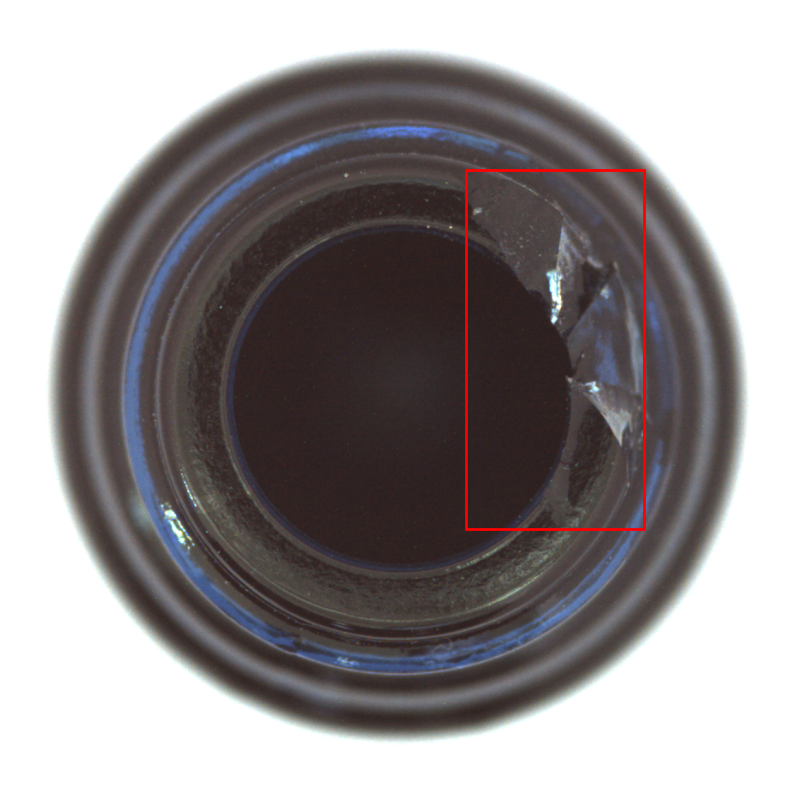

In [ ]:
name = '005'
image = cv2.imread(f'{test_bottles}/{name}.png')

plt.figure(figsize=(10,10))
plt.imshow(image)
show_box(bbox_coords[name], plt.gca())
plt.axis('off')
plt.show()

## Prepare Fine Tuning

In [ ]:
model_type = 'vit_b'
checkpoint = 'sam_vit_b_01ec64.pth'
device = 'cuda:0'

In [ ]:
#loading checkpoint of the SAM weights
from segment_anything import SamPredictor, sam_model_registry
sam_model = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model.to(device)
sam_model.train();

### Image resizing
We convert the input images into a format SAM's internal functions expect.

In [ ]:
# Preprocess the images
from collections import defaultdict

import torch

from segment_anything.utils.transforms import ResizeLongestSide

transformed_data = defaultdict(dict)
for k in bbox_coords.keys():
  image = cv2.imread(f'{train_bottles}/{k}.png')
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
  transform = ResizeLongestSide(sam_model.image_encoder.img_size)
  input_image = transform.apply_image(image)
  input_image_torch = torch.as_tensor(input_image, device=device)
  transformed_image = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]
  
  input_image = sam_model.preprocess(transformed_image)
  original_image_size = image.shape[:2]
  input_size = tuple(transformed_image.shape[-2:])

  transformed_data[k]['image'] = input_image
  transformed_data[k]['input_size'] = input_size
  transformed_data[k]['original_image_size'] = original_image_size


### Hyperparameters

In [ ]:
# Set up the optimizer, learning rate and weight decay
lr = 1e-6
wd = 0
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=lr, weight_decay=wd)

loss_fn = torch.nn.MSELoss()
keys = list(bbox_coords.keys())

## Run fine tuning

### Trainig loop
This is the main training loop. 

Improvements to be made include batching and moving the computation of the image and prompt embeddings outside the loop since we are not tuning these parts of the model, this will speed up training as we should not recompute the embeddings during each epoch. 

In [ ]:
from statistics import mean

from tqdm import tqdm
from torch.nn.functional import threshold, normalize

num_epochs = 70
losses = []

for epoch in range(num_epochs):
  epoch_losses = []
  # Train on the train images
  for k in keys:
    input_image = transformed_data[k]['image'].to(device)
    input_size = transformed_data[k]['input_size']
    original_image_size = transformed_data[k]['original_image_size']
    
    # No grad here as we don't want to optimise the encoders
    with torch.no_grad():
      image_embedding = sam_model.image_encoder(input_image)
      
      prompt_box = bbox_coords[k]
      box = transform.apply_boxes(prompt_box, original_image_size)
      box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
      box_torch = box_torch[None, :]
      
      sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
          points=None,
          boxes=box_torch,
          masks=None,
      )
    low_res_masks, iou_predictions = sam_model.mask_decoder(
      image_embeddings=image_embedding,
      image_pe=sam_model.prompt_encoder.get_dense_pe(),
      sparse_prompt_embeddings=sparse_embeddings,
      dense_prompt_embeddings=dense_embeddings,
      multimask_output=False,
    )

    upscaled_masks = sam_model.postprocess_masks(low_res_masks, input_size, original_image_size).to(device)
    binary_mask = normalize(threshold(upscaled_masks, 0.0, 0)
    )
    if isinstance(ground_truth_masks[k], bool):
        binary_mask_shape = upscaled_masks.shape[-2:]
        gt_binary_mask = torch.ones(binary_mask_shape, dtype=torch.float32).to(device) if ground_truth_masks[k] else torch.zeros(binary_mask_shape, dtype=torch.float32).to(device)
    else:
        print(f"ERROR: ground_truth_masks[k] is not a boolean for key {k}")
        continue
    
    loss = loss_fn(binary_mask, gt_binary_mask)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    epoch_losses.append(loss.item())
  losses.append(epoch_losses)
  print(f'EPOCH: {epoch}')
  print(f'Mean loss: {mean(epoch_losses)}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([900, 900])) that is different to the input size (torch.Size([1, 1, 900, 900])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


EPOCH: 0
Mean loss: 0.10655098516895123
EPOCH: 1
Mean loss: 0.10336456532991178
EPOCH: 2
Mean loss: 0.101955491286526
EPOCH: 3
Mean loss: 0.09985333246108893
EPOCH: 4
Mean loss: 0.10042444476525816
EPOCH: 5
Mean loss: 0.10108308569792826
EPOCH: 6
Mean loss: 0.10181030810376797
EPOCH: 7
Mean loss: 0.10240703762642625
EPOCH: 8
Mean loss: 0.10374900966739915
EPOCH: 9
Mean loss: 0.10840154175780299
EPOCH: 10
Mean loss: 0.11091876543318904
EPOCH: 11
Mean loss: 0.11021635609463373
EPOCH: 12
Mean loss: 0.11057265204540272
EPOCH: 13
Mean loss: 0.10919580263830539
EPOCH: 14
Mean loss: 0.10778098662153753
EPOCH: 15
Mean loss: 0.10777012327885131
EPOCH: 16
Mean loss: 0.10991907283364526
EPOCH: 17
Mean loss: 0.12126524638320006
EPOCH: 18
Mean loss: 0.12114938189210989
EPOCH: 19
Mean loss: 0.11835833177087807
EPOCH: 20
Mean loss: 0.1159512325090418
EPOCH: 21
Mean loss: 0.11540290013531376
EPOCH: 22
Mean loss: 0.11521283814386152
EPOCH: 23
Mean loss: 0.1154311099055576
EPOCH: 24
Mean loss: 0.1179736

Loss misbehaving but can be fixed by tuning the hyper-parameters further. You can play with different learning rates.

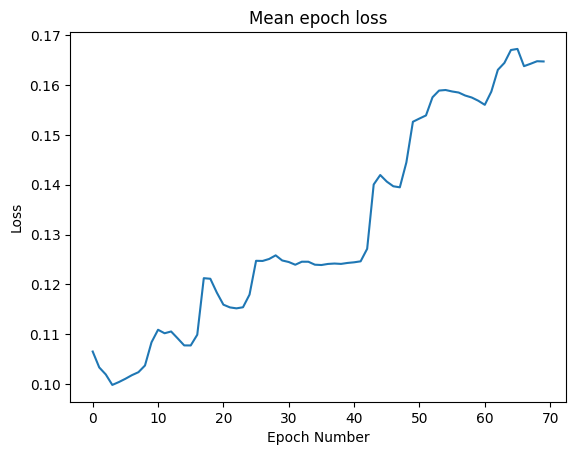

In [ ]:
mean_losses = [mean(x) for x in losses]
mean_losses

plt.plot(list(range(len(mean_losses))), mean_losses)
plt.title('Mean epoch loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')

plt.show()

## Prediction Comparison
 We can compare our tuned model to the original model

In [ ]:
# Load up the model with default weights
sam_model_orig = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model_orig.to(device);

In [ ]:
# Set up predictors for both tuned and original models
from segment_anything import sam_model_registry, SamPredictor
predictor_tuned = SamPredictor(sam_model)
predictor_original = SamPredictor(sam_model_orig)

In [ ]:
# The model has not seen train images therefore you test the masking of the bottles
image = cv2.imread(f'{test_bottles}/{k}.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

predictor_tuned.set_image(image)
predictor_original.set_image(image)

input_bbox = np.array(bbox_coords[k])

masks_tuned, _, _ = predictor_tuned.predict(
    point_coords=None,
    box=input_bbox,
    multimask_output=False,
)

masks_orig, _, _ = predictor_original.predict(
    point_coords=None,
    box=input_bbox,
    multimask_output=False,
)

We can see here that the tuned model is starting to mask a larger potion of the bottle than the original model. With further training, more data and further hyperparameter tuning we will be able to improve this result.



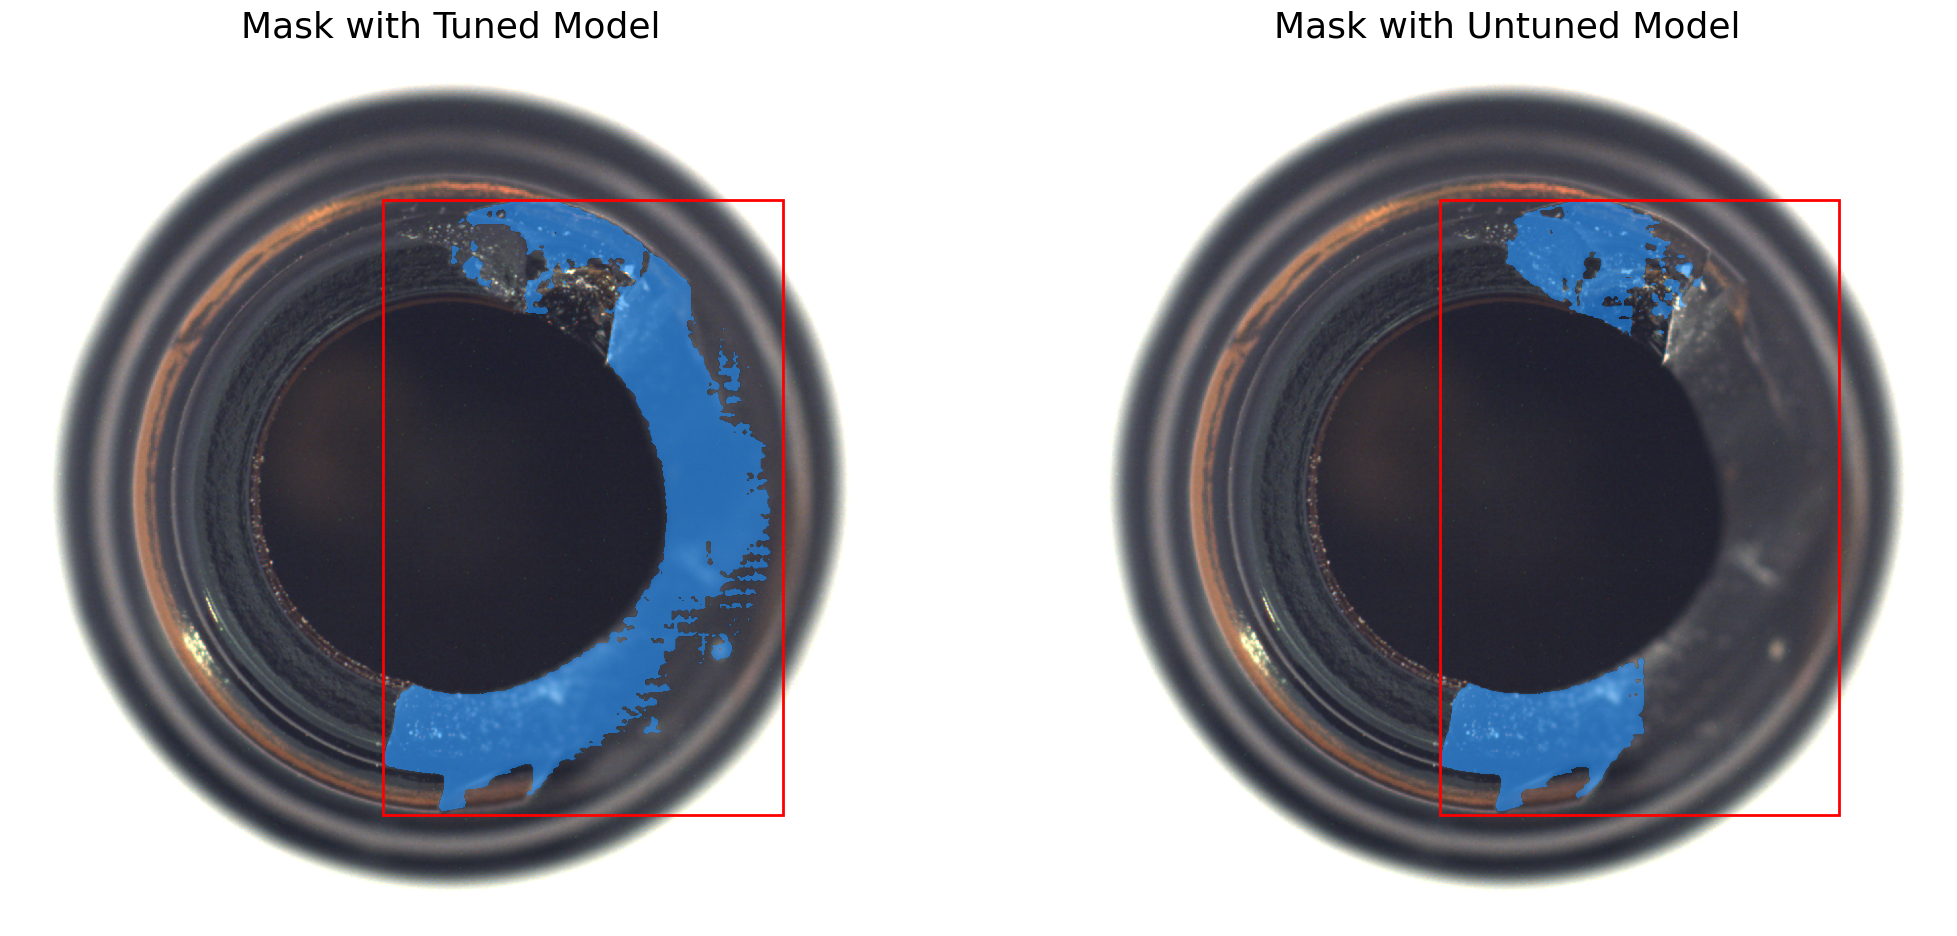

In [ ]:
%matplotlib inline 
_, axs = plt.subplots(1, 2, figsize=(25, 25))


axs[0].imshow(image)
show_mask(masks_tuned, axs[0])
show_box(input_bbox, axs[0])
axs[0].set_title('Mask with Tuned Model', fontsize=26)
axs[0].axis('off')


axs[1].imshow(image)
show_mask(masks_orig, axs[1])
show_box(input_bbox, axs[1])
axs[1].set_title('Mask with Untuned Model', fontsize=26)
axs[1].axis('off')

plt.show()  